In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tqdm import tqdm

In [4]:
# Parameters
N           = 16            # Number of elements
wavelength  = 1.55           # um
d_0         = 3*wavelength  # Element spacing in wavelengths

theta_range = np.radians(np.linspace(-90, 90, 1000))  # Angle range in radian


In [5]:
# Genetic Algorithm parameters
population_size = 100
chromosome_length = N

# Initialize parameters
max_iterations = 1000
mutation_rate  = 0.1
mutation_range = (0.5, 2)

#Convergens parameter 
side_lobe_level       = -10 #db

convergence_threshold = 1 - 10**(side_lobe_level / 20)
convergence_threshold

0.683772233983162

In [6]:
# Computes the array factor of an antenna array given element positions, wavelength, and angle range.

def calculate_array_factor(dn, wavelength, theta_range):
    k = 2 * np.pi / wavelength
    theta = theta_range[np.newaxis, :]  # Shape (1, len(theta_range))

    # Calculate the array factor using vectorized operations
    af = np.sum(np.exp(1j * k * dn * np.sin(theta)), axis=0)
    return np.abs(af)

In [7]:
# Calculates the fitness of a chromosome based on its radiation pattern, assessing grating lobes.

def fittness(individual, wavelength, theta_range):
    
    # Calculate normalized array factor of choromsome 
    arr_fac = calculate_array_factor(individual, wavelength, theta_range)
    normalized_arr_fac = arr_fac / np.max(arr_fac)
    
    # Find peaks (potential lobes) in the array factor
    peaks, _ = find_peaks(normalized_arr_fac)

    # Assuming the main lobe is around 0 degrees, filter out the main lobe
    main_lobe_region = np.radians(2)  # Assuming main lobe width is within ±10 degrees
    filtered_peaks = [p for p in peaks if abs(theta_range[p]) > main_lobe_region]

    if not filtered_peaks:
        return None, None  # No grating lobes found

    # Find the maximum grating lobe
    max_grating_lobe_index = max(filtered_peaks, key=lambda p: normalized_arr_fac[p])
    max_grating_lobe_value = normalized_arr_fac[max_grating_lobe_index]
    max_grating_lobe_angle = np.degrees(theta_range[max_grating_lobe_index])
    
    fit_nes = 1 - max_grating_lobe_value
    return fit_nes

In [8]:
# Function to convert Array Factor to dB
def convert_to_dB(array_factor):
    return 20 * np.log10(array_factor)


In [73]:
# Initializes a population of chromosomes for the genetic algorithm.

def initialize_population(num_elements, pop_size, d_0):
    #Petrubation value
    population = np.zeros(shape = (pop_size, num_elements , 1))
    
    n= np.arange(num_elements)[:, np.newaxis]
    
    for i in range(pop_size):
        delta_d          = np.random.randn(num_elements)[:, np.newaxis]
        delta_d          = delta_d/np.max(delta_d)
        d_n              = n*d_0 + delta_d
        
        population[i, :] = np.abs(d_n)
    
    return population

In [10]:
# Selects parent chromosomes from the population for breeding based on their fitness values.

def select_parents(arr_fac_list, fitness_values):
    """
    Select two best parents from the population based on their fitness.

    Args:
    arr_fac_list (list): The population from which parents are to be selected. Each element is an array.
    fitness_values (list): A list containing the fitness values for each individual in the population.

    Returns:
    tuple: A tuple containing the two best parents.
    """

    # Pair each individual in the population with its corresponding fitness value
    paired_population = list(zip(arr_fac_list, fitness_values))

    # Sort the population based on fitness scores in descending order
    sorted_population = sorted(paired_population, key=lambda x: x[1], reverse=True)

    # Select the top two individuals as parents
    parent1, parent2 = sorted_population[0][0], sorted_population[1][0]

    return parent1, parent2


In [11]:
# Exchanges segments of genetic material between two parent chromosomes at two crossover points, producing offspring.
def two_point_crossover(parent1, parent2):
    """
    Perform two-point crossover between two parents.
    
    Args:
    parent1 (array-like): The first parent (an array of genes).
    parent2 (array-like): The second parent (an array of genes).
    
    Returns:
    tuple: Two offspring, each an array of genes.
    """


    length = len(parent1)
    
    # Randomly select two crossover points
    crossover_point1 = np.random.randint(1, length)
    crossover_point2 = np.random.randint(1, length)

    # Ensure that the first crossover point is less than the second
    if crossover_point1 > crossover_point2:
        crossover_point1, crossover_point2 = crossover_point2, crossover_point1
    
    # Create offspring by combining the genes of the parents
    offspring1 = np.concatenate([parent1[:crossover_point1], parent2[crossover_point1:crossover_point2], parent1[crossover_point2:]])
    offspring2 = np.concatenate([parent2[:crossover_point1], parent1[crossover_point1:crossover_point2], parent2[crossover_point2:]])

    return (offspring1, offspring2)




In [14]:
def replace(population, fit_values, new_individuals, new_fit_values):
    """
    Add new individuals to the population if they are fitter than the average fitness, 
    replacing the least fit individuals in the population.
    """
    num_new_individuals = len(new_individuals)
    # Sort the fitness values and get indices of the least fit individuals
    sorted_indices = np.argsort(fit_values)[:num_new_individuals]

    # Create a copy of the population to modify
    updated_population = np.copy(population)

    for i in range(num_new_individuals):
        # Replace the least fit individuals with the new, fitter individuals
        updated_population[sorted_indices[i]] = new_individuals[i]
    
    return updated_population

In [15]:
# Adds new individuals to the population if they are fitter than the average fitness, replacing the least fit individuals.
def update_population(population, fit_values, offspring, offspring_fit_values):
    """
    Update the population with offspring if they are fitter than the average fitness of the population.
    """
    average_fitness = np.mean(fit_values)
    fitter_offspring = np.array([child for child, fitness in zip(offspring, offspring_fit_values) if fitness > average_fitness])

    # Replace the least fit individuals with fitter offspring if there are fitter offspring
    if len(fitter_offspring) != 0:
        updated_population = replace(population, fit_values, fitter_offspring, offspring_fit_values)
        return updated_population 
    else:
        return population  # Return a copy of the original population if no update is made


In [16]:
# Performs a uniform mutation on a single chromosome within a specified range.
def uniform_mutation(chromosome, mutation_range):
    """ Perform uniform mutation on a single chromosome by adding a random value to each gene """
   
    # Randomly choose an index for mutation
    mutation_values = np.random.uniform(mutation_range[0], mutation_range[1], size=(len(chromosome),1))
   
    # Replace the value at this index with a random value within the mutation range
    mutated_chromosome = chromosome + mutation_values
    
    return mutated_chromosome

In [17]:
# Mutates a specified number of chromosomes in a population, using the uniform_mutation function.
def mutate_population(population, n, mutation_range):
    """ Mutate n unique chromosomes in the population using the revised uniform mutation with numpy. """
    
    # Create a deep copy of the population
    mutated_population = np.copy(population)
    
    # Choose n unique indices for mutation
    indices_to_mutate = np.random.choice(len(population), n, replace=False)

    for index in indices_to_mutate:
        # Mutate the selected chromosome
        mutated_population[index] = uniform_mutation(mutated_population[index], mutation_range)

    return mutated_population

In [18]:
#Shifts and Sorts the Optimal chromosome values 
def sort_shift(chromosome):
    # Sort the chromosome first
    sorted_chromosome = np.sort(chromosome, axis=0)

    # Calculate the difference between each element and the first element
    diff_values = sorted_chromosome - sorted_chromosome[0]

    # Sort the array of difference values
    sorted_diff_values = np.sort(diff_values, axis=0)

    return sorted_diff_values

In [19]:
#Rounds chromosome values
def round_float_array(arr, max_resolution=1):
    # Round all values in the array to the specified resolution
    rounded_arr = np.round(arr, decimals=max_resolution)
    
    return rounded_arr

In [78]:
population = initialize_population(chromosome_length, population_size, d_0)
fit_values = np.array([fittness(individual, wavelength, theta_range) for individual in population])
max_values = []

In [79]:
# Main Genetic Algorithm loop
for iteration in tqdm(range(max_iterations)):
    # Select parents
    parent1, parent2 = select_parents(population, fit_values)

    # Crossover
    offspring1, offspring2 = two_point_crossover(parent1, parent2)
    offspring = np.array([offspring1, offspring2])

    # Calculate fitness of offspring
    offspring_fit_values = np.array([fittness(child, wavelength, theta_range) for child in offspring])

    # Update population
    population = update_population(population, fit_values, offspring, offspring_fit_values)

    # Mutate population
    num_mutations = int(mutation_rate * population_size)
    population = mutate_population(population, num_mutations, mutation_range)

    # Calculate fitness of mutated population
    fit_values = np.array([fittness(individual, wavelength, theta_range) for individual in population])
    max_values.append((fit_values.max(),population[np.argmax(fit_values)]))
    
    if fit_values.max() >= convergence_threshold:
        print(f"The shortest path in pop is in index{np.argmax(fit_values)}")
        print(population[np.argmax(fit_values)])
        break


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:23<00:00,  3.10it/s]


In [130]:
sort_shift(population[np.argmax(fit_values)])

array([[ 0.        ],
       [31.4051778 ],
       [33.82115862],
       [34.72978754],
       [37.47264592],
       [38.74636733],
       [40.23398586],
       [41.49539921],
       [43.824484  ],
       [44.72413343],
       [45.86026366],
       [46.25599208],
       [48.35572736],
       [49.64630586],
       [53.26964989],
       [54.60677089]])

In [80]:
max_val = []

In [81]:
for i in range(len(max_values)):
    max_val.append(max_values[i][0])

In [82]:
for i in range(len(max_values)):
    if max_values[i][0] == max(max_val):
        index = i
        break

In [ ]:
inter = np.arange(len(max_values))

In [156]:
sv_distance = loaded_array = np.load('Array_of_distances.npy')
rand_dist  = initialize_population(chromosome_length, population_size, d_0 )[0]
eq_dist = np.array([n * d_0 for n in range(N)])[:, np.newaxis]

In [157]:
ar_sp = "Randomized "
name_log = f"Logarithmic Array Factor of a Linear Phased Array with {ar_sp }  Spacing"
name_norm = f"'Normalized Array Factor of a Linear Phased Array with {ar_sp }  Spacing"
name_polar = f" Array Factor of a Linear Phased Array with {ar_sp }  Spacing"
fil_name_log= f"Logarithmic Array Factor of a Linear Phased Array with {ar_sp }  Spacing.jpeg"
fil_name_norm  = f"'Normalized Array Factor of a Linear Phased Array with {ar_sp }  Spacing.jpeg"
fil_name_polar =  f" Array Factor of a Linear Phased Array with {ar_sp }  Spacing.jpeg"


In [158]:
af_vec = calculate_array_factor(rand_dist,wavelength, theta_range)
af_normalized_vec = af_vec / np.max(af_vec)

af_db = convert_to_dB(af_normalized_vec)

In [138]:
af_vec = calculate_array_factor(sort_shift(max_values[index][1]),wavelength, theta_range)
af_normalized_vec = af_vec / np.max(af_vec)

af_db = convert_to_dB(af_normalized_vec)

NameError: name 'max_values' is not defined

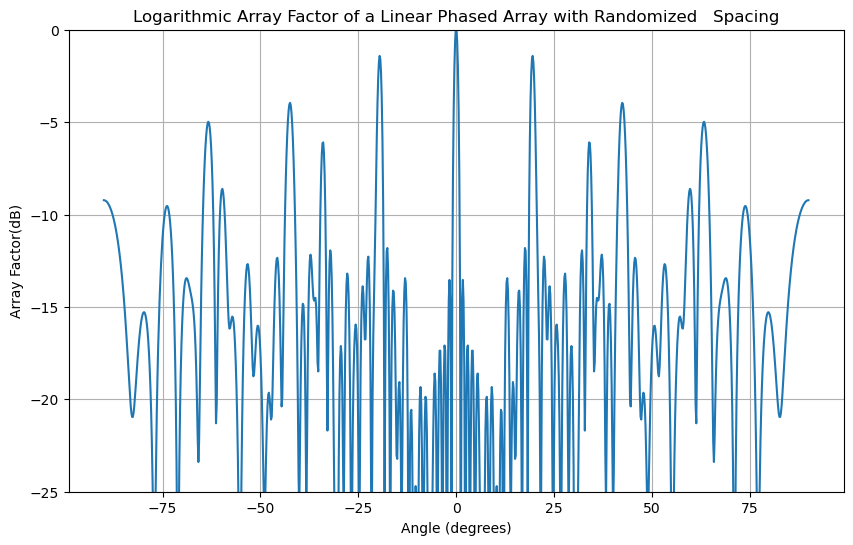

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(np.degrees(theta_range), af_db)
plt.ylim(-25, 0)
plt.xlabel("Angle (degrees)")
plt.ylabel("Array Factor(dB)")
plt.title(name_log)
plt.grid(True)
plt.savefig(fil_name_log)

plt.show()

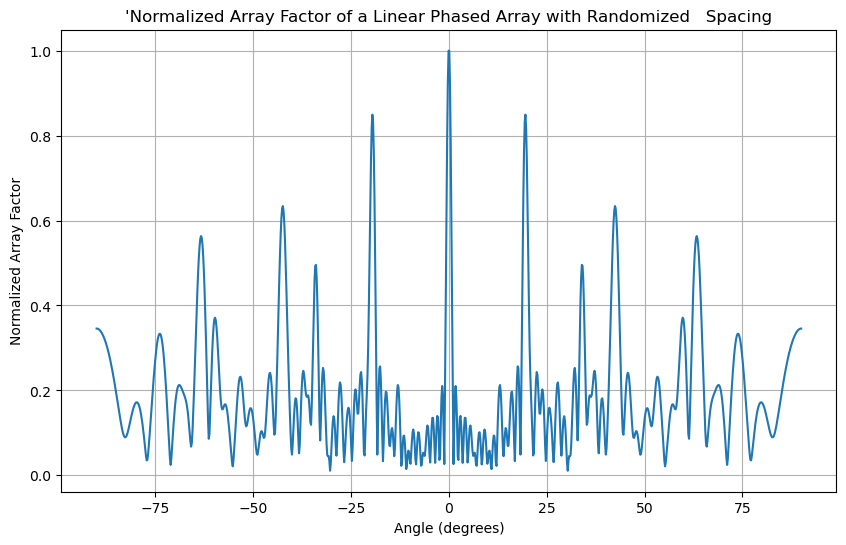

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(np.degrees(theta_range), af_normalized_vec)
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Array Factor")
plt.title(name_norm)
plt.grid(True)
plt.savefig(fil_name_norm)

plt.show()

In [161]:
af_db_limited = np.clip(af_db, -50, None)

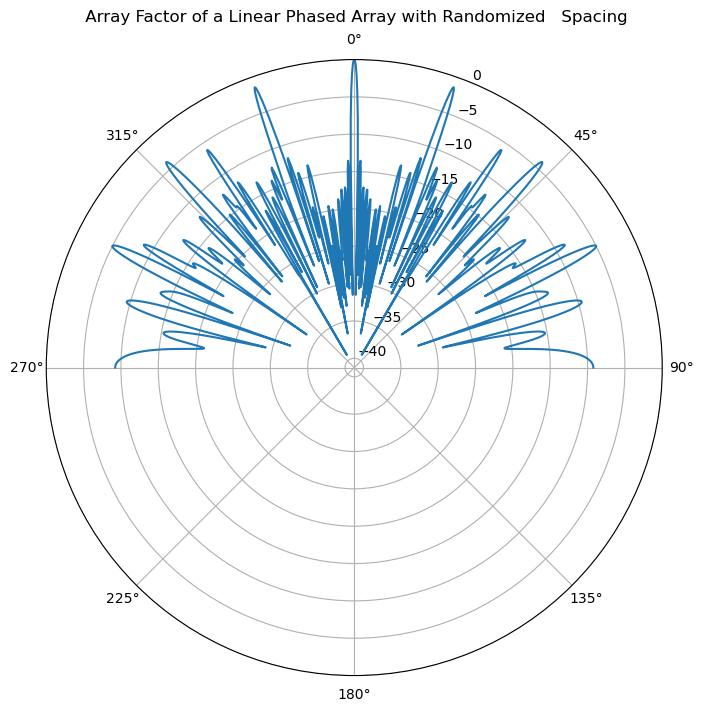

In [162]:
# Plotting in polar coordinates
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(theta_range, af_db_limited)
ax.set_theta_zero_location("N")  # Set the direction of the zero degree
ax.set_theta_direction(-1)  # Set the direction of increasing angles to clockwise
ax.set_title(name_polar, va='bottom')
plt.savefig(fil_name_polar)

plt.show()